In [1]:
import ssl

# Set the path to the CA certificates bundle
ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
import pandas as pd
from matplotlib import pyplot as plt

# Load a modified version of the Spambase dataset
df = pd.read_csv('https://github.com/Explore-AI/Public-Data/blob/master/Data/classification_sprint/unbalanced_email_spam_data.csv?raw=true')

In [3]:
df.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,spam
0,0.00,0.0,1.63,0.0,0.00,0.0,0.00,0.0,0.0,0.00,...,0.000,0.000,0.000,2.695,0.000,0.000,2.315,12,44,1
1,0.00,0.0,0.00,0.0,0.26,0.0,0.26,0.0,0.0,0.00,...,0.462,0.084,0.084,0.378,0.000,1.051,13.820,104,1078,1
2,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.00,...,0.000,0.000,0.000,0.000,3.260,0.000,2.444,10,44,1
3,0.25,0.0,0.25,0.0,0.50,0.0,0.25,0.0,0.0,0.00,...,0.000,0.041,0.000,0.082,0.041,0.041,1.890,18,225,1
4,0.25,0.5,0.50,0.0,0.00,0.0,0.00,0.0,0.0,0.25,...,0.000,0.181,0.000,0.407,0.997,0.000,3.417,49,270,1


In [4]:
#Quick analysis of the distribution of observations across our labels.

# Separate minority and majority classes
not_spam = df[df['spam']==0]
spam = df[df['spam']==1]

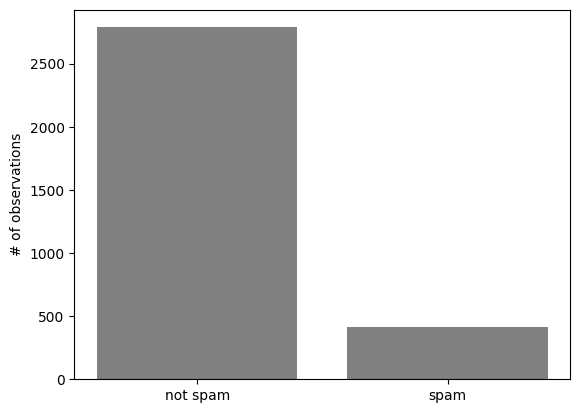

In [5]:
# Get all possible labels
labels = df['spam'].unique()
heights = [len(spam),len(not_spam)]
plt.bar(labels,heights,color='grey')
plt.xticks(labels,['spam','not spam'])
plt.ylabel("# of observations")
plt.show()

In [6]:
# Percentage of non-spam emails in the dataset
len(not_spam)/(len(df))

0.8709778194314277



As you can see, our two classes are imbalanced. To put this in perspective as to why this is such an issue, say we had a model that always predicts that a given email is not spam (clearly a really bad model!). Such a model would achieve an accuracy of 87%! This is why (as explained in previous trains) class imbalance can be a serious problem if left unchecked.

Let's use resampling techniques to fix this. Notice that we are keeping our features and labels together for the time being so that they get sampled together (otherwise we risk mixing labels and observations):


In [7]:
from sklearn.utils import resample

Approach 1 – Downsampling the majority class

Since the not_spam class has so many observations, we can reduce its size by taking a small random subset of observations to match the size of the spam class. Because this approach reduces the overall size of the dataset, it makes sense to use it only in cases where we have a big collection of data.

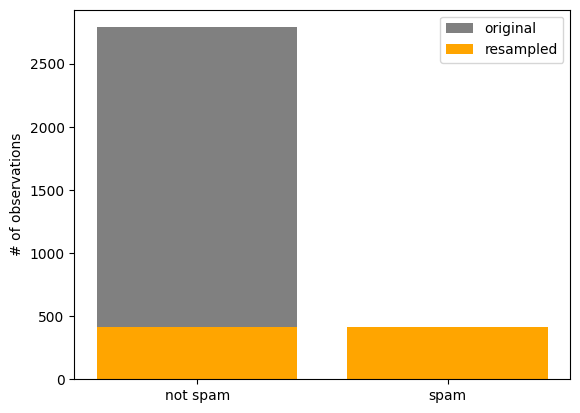

In [8]:
# Downsample majority
not_spam_downsampled = resample(not_spam,
                          replace=False, # sample without replacement (no need to duplicate observations)
                          n_samples=len(spam), # match number in minority class
                          random_state=27) # reproducible results

# Combine downsampled majority class with minority class
downsampled = pd.concat([not_spam_downsampled, spam])

# Check new class counts
downsampled['spam'].value_counts()

downsampled_heights = [len(downsampled[downsampled['spam']==0]),len(downsampled[downsampled['spam']==1])]

# Get all possible labels
labels = df['spam'].unique()
plt.bar(labels,heights,color='grey')
plt.bar(labels,downsampled_heights,color='orange')
plt.xticks(labels,['spam','not spam'])
plt.ylabel("# of observations")
plt.legend(['original','resampled'])
plt.show()

#### Upsampling the minority class

Here, we simply make random copies of observations in the minority class until we match the size of the majority class. Using this approach means we end up with more data.

In [9]:
# Upsample minority
spam_upsampled = resample(spam,
                          replace=True, # sample with replacement (we need to duplicate observations)
                          n_samples=len(not_spam), # match number in minority class
                          random_state=27) # reproducible results

# Combine upsampled minority class with majority class
upsampled = pd.concat([spam_upsampled, not_spam])

# Check new class counts
upsampled['spam'].value_counts()

spam
1    2788
0    2788
Name: count, dtype: int64

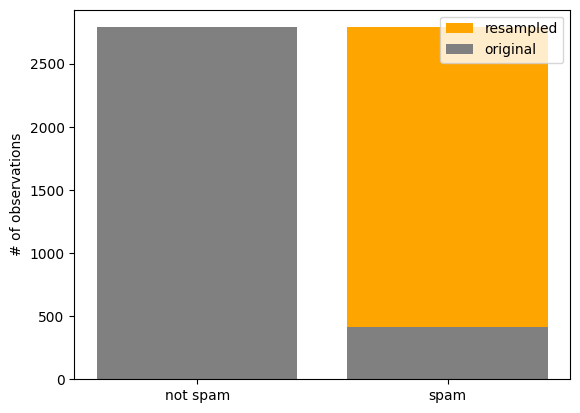

In [10]:
upsampled_heights = [len(upsampled[upsampled['spam']==0]),len(upsampled[upsampled['spam']==1])]

# Get all possible labels
labels = df['spam'].unique()
plt.bar(labels,upsampled_heights,color='orange')
plt.bar(labels,heights,color='grey')
plt.xticks(labels,['spam','not spam'])
plt.ylabel("# of observations")
plt.legend(['resampled','original'])
plt.show()

#### Best of both (upsample minority class and downsample majority class)

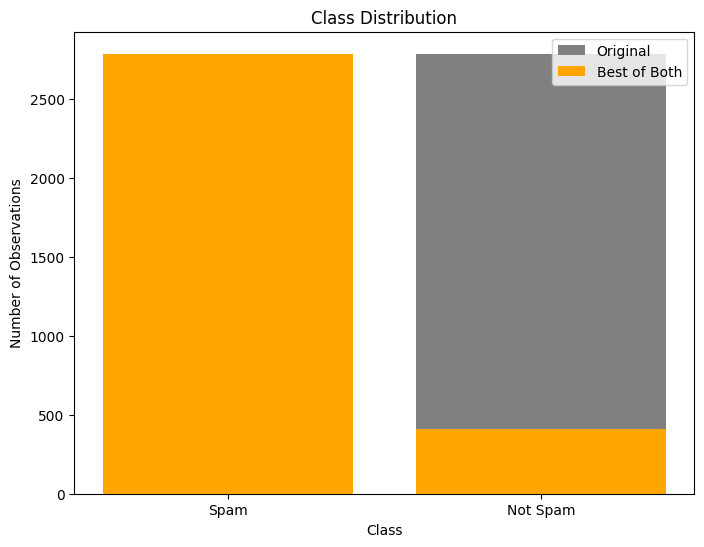

In [11]:
# Downsample majority
not_spam_downsampled = resample(not_spam,
                               replace=False,  # sample without replacement
                               n_samples=len(spam),  # match number in minority class
                               random_state=27)  # reproducible results

# Upsample minority
spam_upsampled = resample(spam,
                         replace=True,  # sample with replacement
                         n_samples=len(not_spam),  # match number in majority class
                         random_state=27)  # reproducible results

# Combine upsampled minority class and downsampled majority class
best_of_both = pd.concat([spam_upsampled, not_spam_downsampled])

# Check new class counts
best_of_both['spam'].value_counts()

# Plot the final output
original_heights = [len(df[df['spam']==0]), len(df[df['spam']==1])]
best_of_both_heights = [len(best_of_both[best_of_both['spam']==0]), len(best_of_both[best_of_both['spam']==1])]

# Get all possible labels
labels = df['spam'].unique()

# Create the plot
plt.figure(figsize=(8, 6))
plt.bar(labels, original_heights, color='grey', label='Original')
plt.bar(labels, best_of_both_heights, color='orange', label='Best of Both')
plt.xticks(labels, ['Not Spam', 'Spam'])
plt.xlabel('Class')
plt.ylabel('Number of Observations')
plt.title('Class Distribution')
plt.legend()
plt.show()